<a href="https://colab.research.google.com/github/Julia891021/954/blob/main/AIproject31_faceshape_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch
!pip install torchvision
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7ec9f046274e505d581b36e583b3cd4dbc4545a5057191ca677665be951e7b74
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 串接雲端硬碟

In [361]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/AI_Team31')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [ ]:
# Check data directory
os.listdir("FaceShape Dataset")

['desktop.ini', 'testing_set', 'training_set']

### Split train, val 

In [ ]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    train, test = [], []
    for dset in os.listdir(data_dir):
        # check is directory
        subdir = os.path.join(data_dir, dset)
        if os.path.isdir(subdir):
            for label in os.listdir(subdir):
                imgdir = os.path.join(subdir, label)
                if os.path.isdir(imgdir):
                    for image_path in os.listdir(imgdir):
                        if image_path.endswith(".jpg"):
                            sample = {
                                "path": os.path.join(subdir, label, image_path),
                                "label": label
                            }
                            if dset == "training_set":
                                train.append(sample)
                            elif dset == "testing_set":
                                test.append(sample)
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

train_df, val_df, test_df = split_train_val("FaceShape Dataset")
test_df

,path,label
0,FaceShape Dataset/testing_set/Oblong/oblong (2...,Oblong
1,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
2,FaceShape Dataset/testing_set/Oblong/oblong (3...,Oblong
3,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
4,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
...,...,...
995,FaceShape Dataset/testing_set/Heart/heart (788...,Heart
996,FaceShape Dataset/testing_set/Heart/heart (726...,Heart
997,FaceShape Dataset/testing_set/Heart/heart (453...,Heart
998,FaceShape Dataset/testing_set/Heart/heart (455...,Heart


### Visualize some images and labels

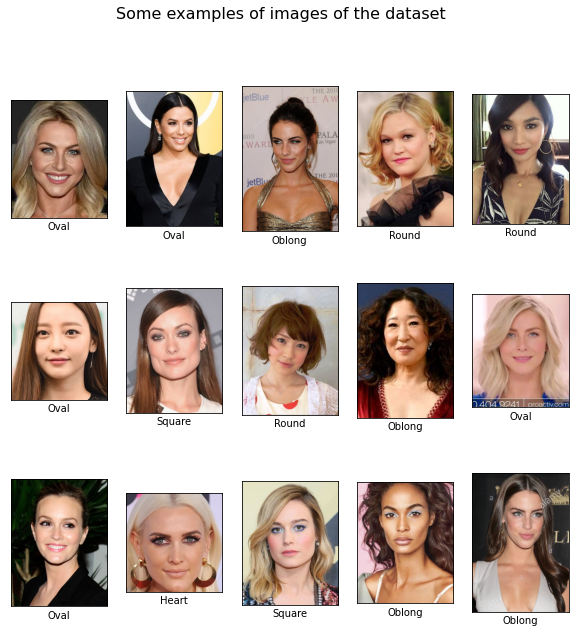

In [ ]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [ ]:
# Dataset
class FaceShapeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

   
    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### EfficientNet

In [ ]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=5):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_model.pth")
            print("Saved best model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

### Start Training

In [ ]:
# Configs
class args:
    data_dir="FaceShape Dataset"
    batch_size=32
    n_epochs=20
    learning_rate=0.001
    debug=False

In [ ]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

import time
from datetime import timedelta
st = time.time()
print("-------- Start training --------")
model = EffNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

-------- Start training --------


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


Training Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (836).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 2.1817, Accuracy: 124/400 (31%)

Saved best model
Best accuracy: 31.0


Training Epoch 2:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.5892, Accuracy: 186/400 (46%)

Saved best model
Best accuracy: 46.5


Training Epoch 3:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.8299, Accuracy: 169/400 (42%)

Best accuracy: 46.5


Training Epoch 4:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.3560, Accuracy: 252/400 (63%)

Saved best model
Best accuracy: 63.0


Training Epoch 5:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.4450, Accuracy: 268/400 (67%)

Saved best model
Best accuracy: 67.0


Training Epoch 6:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.4459, Accuracy: 280/400 (70%)

Saved best model
Best accuracy: 70.0


Training Epoch 7:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.3158, Accuracy: 273/400 (68%)

Best accuracy: 70.0


Training Epoch 8:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.6901, Accuracy: 238/400 (60%)

Best accuracy: 70.0


Training Epoch 9:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.9770, Accuracy: 258/400 (64%)

Best accuracy: 70.0


Training Epoch 10:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.0485, Accuracy: 295/400 (74%)

Saved best model
Best accuracy: 73.75


Training Epoch 11:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 11:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.0668, Accuracy: 306/400 (76%)

Saved best model
Best accuracy: 76.5


Training Epoch 12:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 12:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.7037, Accuracy: 263/400 (66%)

Best accuracy: 76.5


Training Epoch 13:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 13:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.5726, Accuracy: 266/400 (66%)

Best accuracy: 76.5


Training Epoch 14:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 14:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 0.8746, Accuracy: 313/400 (78%)

Saved best model
Best accuracy: 78.25


Training Epoch 15:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 15:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.2951, Accuracy: 295/400 (74%)

Best accuracy: 78.25


Training Epoch 16:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 16:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.2702, Accuracy: 279/400 (70%)

Best accuracy: 78.25


Training Epoch 17:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 17:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 0.8381, Accuracy: 317/400 (79%)

Saved best model
Best accuracy: 79.25


Training Epoch 18:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 18:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.4553, Accuracy: 269/400 (67%)

Best accuracy: 79.25


Training Epoch 19:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 19:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.1458, Accuracy: 300/400 (75%)

Best accuracy: 79.25


Training Epoch 20:   0%|          | 0/113 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 20:   0%|          | 0/13 [00:00<?, ?it/s]


Validation set: Average loss: 1.0957, Accuracy: 316/400 (79%)

Best accuracy: 79.25
-------- End training, time taken: 1:08:07


### Predict on test set

In [ ]:
test_ds = FaceShapeDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)

model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        y_true += target.view(-1).tolist()
        y_pred += pred.view(-1).tolist()
        
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 1.1598, Accuracy: 759/1000 (76%)

              precision    recall  f1-score   support

       Heart       0.63      0.89      0.73       200
      Oblong       0.83      0.79      0.81       200
        Oval       0.79      0.54      0.64       200
       Round       0.78      0.74      0.76       200
      Square       0.83      0.84      0.84       200

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



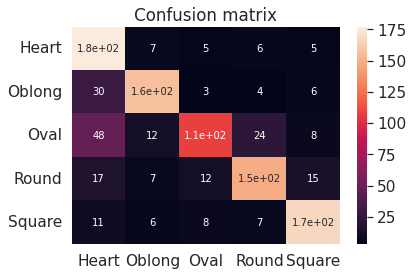

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

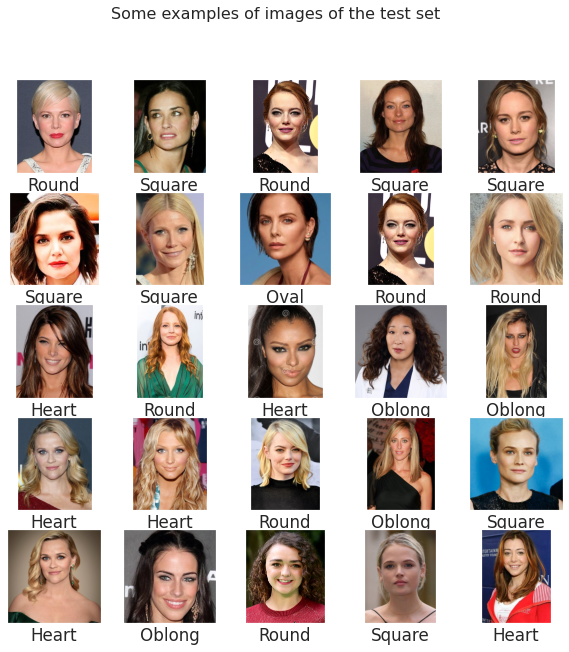

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


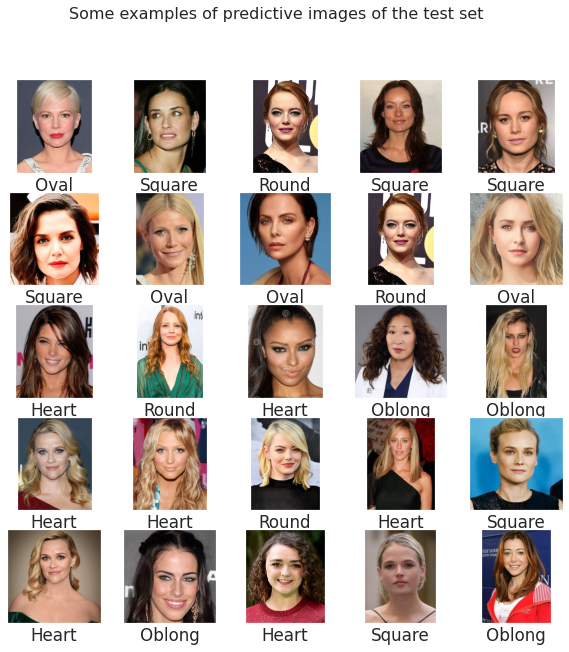

In [ ]:
def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of predictive images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_pred[idx])
    plt.show()

display_examples()

----------------Test-----------------------

In [ ]:
!pip install face_recognition
import os
import face_recognition
from PIL import Image, ImageDraw
import torchvision.transforms as T

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 36 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=55d0668a323997338264a959d6f31c2d3ce25e3f4cf19d671ae7610db84508aa
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [364]:
def get_Remove_BG(test_ds, y_pred):
  transform = T.ToPILImage()
  img = transform(test_ds[0]) #tensor轉img
  img=np.array(img) #img轉array
  
  img_bgr=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) #灰階轉BGR
  plt.imshow(img_bgr)
  img_rgb = img_bgr[:, :, [2, 1, 0]]  #BGR轉RGB
  known_image = img_rgb
  # 已知人臉位置的臉部編碼
  face_locations = face_recognition.face_locations(known_image, number_of_times_to_upsample=1, model="cnn")
  print("照片共辨識出 {} 張臉。".format(len(face_locations)))
  #print(face_locations[0])
  known_image_encodings = face_recognition.face_encodings(known_image, known_face_locations=face_locations, num_jitters=10)[0]
  print("照片共產生 {} 組特徵值。".format(len(known_image_encodings)))
  # 相同臉型人臉位置的臉部編碼(Hair Sample)
  new_image_path_list=[]
  dataPath = os.getcwd()+"/Hair_Sample/" + y_pred
  foldername = os.listdir(dataPath)
  for folder in foldername:
    new_image_path_list.append(os.path.join(dataPath,folder))
  euclidean_distance_list=[]  
  for i in range(len(new_image_path_list)):
    new_image_path = new_image_path_list[i]
    new_image = face_recognition.load_image_file(new_image_path,mode = 'RGB')
    new_image_encoding = face_recognition.face_encodings(new_image)[0]
    # 進行計算並顯示結果
    euclidean_distance = face_recognition.face_distance([known_image_encodings], new_image_encoding)
    euclidean_distance_list.append(euclidean_distance)
  # print(euclidean_distance_list)
  euclidean_distance_list_copy = euclidean_distance_list.copy()
  euclidean_distance_list_copy.sort()  #小到大
  index=[]
  for i in range(3):  #取distance前三小的
    index.append(euclidean_distance_list.index(euclidean_distance_list_copy[i][0])+1)
  result=[]
  for i in range(len(index)):
    # Remove_BG = os.getcwd()+"/Hair_Sample/Remove_BG/" + y_pred + "/" + y_pred + str(index[i])+".png"
    Remove_BG = os.getcwd()+"/Hair_Sample/" + y_pred + "/" + y_pred +str(index[i])+".jpeg"
    Remove_BG_BGR = cv2.imread(Remove_BG)
    Remove_BG_RGB = Remove_BG_BGR[:, :, [2, 1, 0]]   #BGR轉RGB
    result.append(Remove_BG_RGB) 
  return img_bgr,result

照片共辨識出 1 張臉。
照片共產生 128 組特徵值。


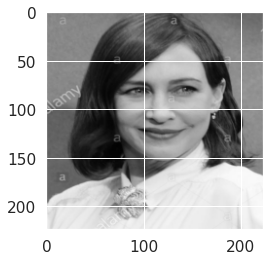

In [365]:
pic,hair=get_Remove_BG(test_ds[100], y_pred[100])
# plt.imshow(pic)
# pic.shape
# plt.imshow(hair[1])

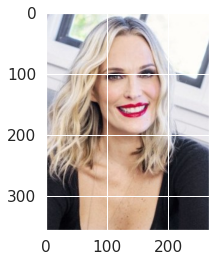

In [366]:
plt.imshow(hair[2])

In [329]:
img_rgb.shape

(224, 224, 3)